Import dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import build_montages
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

Load data

In [2]:
((X_train, _), (X_test, _)) = tf.keras.datasets.fashion_mnist.load_data()
X_train.shape, X_test.shape

4422102/4422102 [==============================] - 1s 0us/step


((60000, 28, 28), (10000, 28, 28))

Adding channel dimension for compatibility with conv2D

In [3]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

Representation image

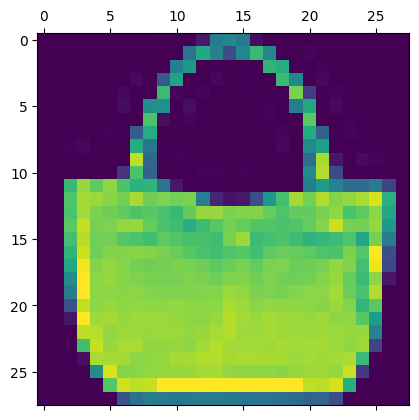

In [6]:
plt.matshow(X_train[100])

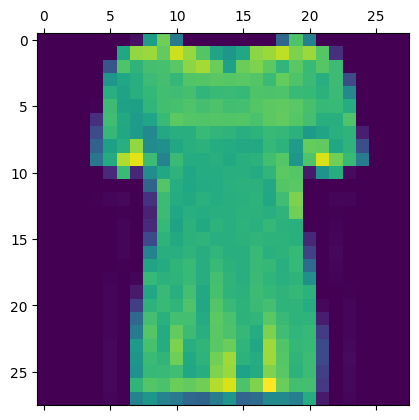

In [7]:
plt.matshow(X_train[10])

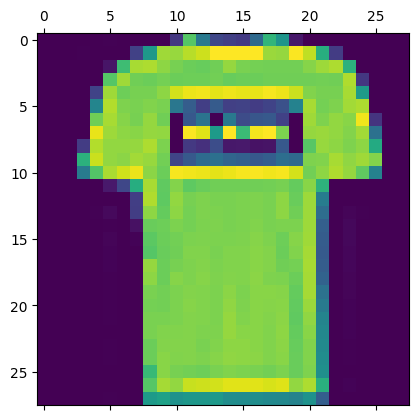

In [8]:
plt.matshow(X_train[1])

Train and test images Combination

In [9]:
trainImages = np.concatenate([X_train, X_test])
trainImages = (trainImages.astype("float") - 127.5) / 127.5

Hyperparameters

In [10]:
latent_dim = 100
height = 28
width = 28
nb_channels = 1

Generator

In [11]:
def generator_network():
    generator = Sequential()
    inputShape = (7, 7, 64)
    chanDim = -1

    generator.add(Dense(input_dim=latent_dim, units=512))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Dense(7 * 7 * 64))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Reshape(inputShape))
    generator.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
        padding="same"))
    generator.add((LeakyReLU()))
    generator.add(BatchNormalization(axis=chanDim))

    generator.add(Conv2DTranspose(nb_channels, (5, 5), strides=(2, 2),
        padding="same", activation="tanh"))

    return generator

In [12]:
generator = generator_network()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3136)              1608768   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 3136)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 3136)             12544     
 hNormalization)                                        

Discriminator

In [13]:
def disc_network():
    disc = Sequential()
    inputShape = (height, width, nb_channels)

    disc.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
        input_shape=inputShape))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Flatten())
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dropout(0.3))
    disc.add(Dense(1))
    disc.add(Activation("sigmoid"))

    return disc

In [14]:
disc = disc_network()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1606144   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)              

Optimizer

In [16]:
disc_opt = tf.keras.optimizers.legacy.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
disc.compile(optimizer=disc_opt, loss="binary_crossentropy")

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#GAN

In [19]:
disc.trainable = False
gan_input = Input(shape=(latent_dim, ))
gan_output = disc(generator(gan_input))
gan = Model(gan_input, gan_output)
gan_opt = tf.keras.optimizers.legacy.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
gan.compile(loss="binary_crossentropy", optimizer=gan_opt)
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         1727233   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1658753   
                                                                 
Total params: 3,385,986
Trainable params: 1,719,873
Non-trainable params: 1,666,113
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training

In [ ]:
epochs = 10000
batch_size = 20
start = 0
for epoch in tqdm(range(epochs)):
    benchmark_noise = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(benchmark_noise)
    stop = start + batch_size
    real_images = trainImages[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.array(([1] * batch_size) + ([0] * batch_size)).astype("float")
    labels += 0.05 * np.random.random(labels.shape)
    (combined_images, labels) = shuffle(combined_images, labels)
    d_loss = disc.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    fake_labels = np.array([0] * batch_size)
    a_loss = gan.train_on_batch(random_latent_vectors, fake_labels)
    start += batch_size
    if start > len(trainImages) - batch_size:
        start = 0
    if epoch % 500 == 0:
        print(f"Step: {epoch} Disc Loss: {d_loss} Adv Loss: {a_loss}")
        images = ((generated_images * 127.5) + 127.5).astype("int")
        images = np.repeat(images, 3, axis=-1)
        vis = build_montages(images, (28, 28), (4, 5))[0]
        cv2.imwrite("vis" + str(epoch) + ".png", vis)

Images generation using the generator

In [22]:
benchmark_noise = np.random.normal(size=(batch_size, latent_dim))
generated_images = generator.predict(benchmark_noise)
images = ((generated_images * 127.5) + 127.5).astype("int")
images.shape

1/1 [==============================] - 0s 21ms/step


(20, 28, 28, 1)

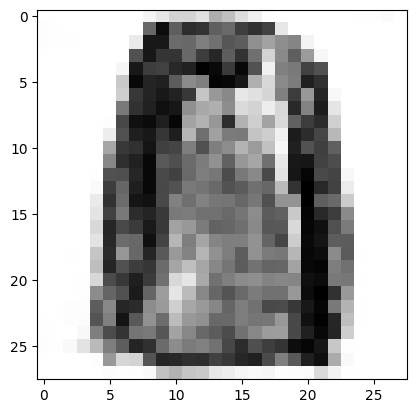

In [23]:
random_idx = np.random.choice(images.shape[0], 1)
image_1 = images[random_idx].reshape(28, 28)
plt.imshow(image_1, cmap=plt.cm.binary)
plt.show()

Adversarial examples

In [24]:
def get_train_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3, 3), activation='relu')
    ])

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [25]:
((X_train, y_train), (X_test, y_test)) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
X_train = X_train / 255.
X_test = X_test / 255.
apparel_model = get_train_model()
history = apparel_model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  batch_size=128,
                  epochs=10)

Epoch 1/10
469/469 [==============================] - 7s 6ms/step - loss: 0.5971 - accuracy: 0.7861 - val_loss: 0.4407 - val_accuracy: 0.8398
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3712 - accuracy: 0.8653 - val_loss: 0.3815 - val_accuracy: 0.8634
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3221 - accuracy: 0.8834 - val_loss: 0.3334 - val_accuracy: 0.8793
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2897 - accuracy: 0.8948 - val_loss: 0.3164 - val_accuracy: 0.8865
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2667 - accuracy: 0.9018 - val_loss: 0.2969 - val_accuracy: 0.8919
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.2462 - accuracy: 0.9102 - val_loss: 0.2858 - val_accuracy: 0.8939
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2325 - accuracy: 0.9147 - val_loss: 0.2702 - val_accuracy: 0.9016
Epoch 

Plot training progress

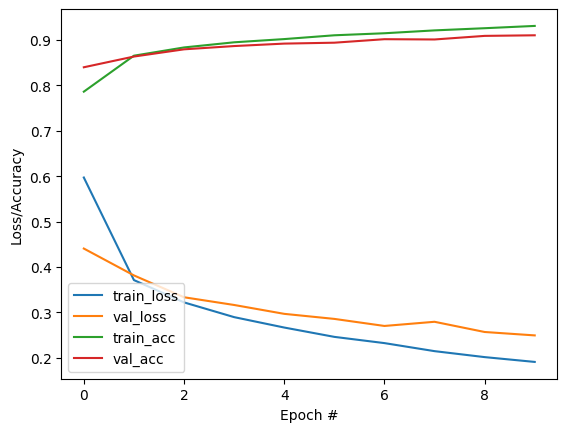

In [26]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [27]:
LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Adversarial example

In [28]:
EPS = 1./10000

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

def generate_adversaries_targeted(image_tensor, delta,
    true_index, target_index, model):
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-1)

    for t in range(300):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)/255
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) +
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())

        gradients = tape.gradient(loss, delta)
        optimizer.apply_gradients([(gradients, delta)])
        delta.assign_add(clip_eps(delta))
    return delta

In [29]:
def perturb_image(image, true, target, model):
    plt.imshow((image.reshape(28, 28)), cmap=plt.cm.binary)
    image = np.expand_dims(image, 0)
    unsafe_preds = model.predict(image)
    print('Predicted before adv.:', LABELS[unsafe_preds[0].argmax()])
    image_tensor = tf.constant(image*255, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, true, target, model)
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255, cmap=plt.cm.binary)
    plt.show()
    perturbed_image = (image_tensor + delta_tensor)/255
    preds = model.predict(perturbed_image)
    print('Predicted:', LABELS[preds[0].argmax()])
    return (image_tensor + delta_tensor)/255

Select an Image

Original label  Coat
1/1 [==============================] - 0s 385ms/step
Predicted before adv.: Coat


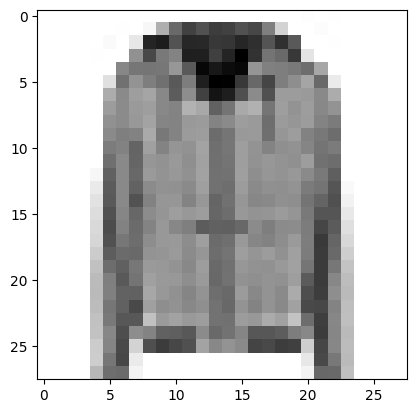

0 13.040106
20 8.927541
40 4.8363104
60 -0.10566139
80 -4.201503
100 -7.0147123
120 -9.743977
140 -12.548687
160 -14.934566
180 -17.097996
200 -19.075703
220 -21.001194
240 -22.906069
260 -24.73209
280 -26.548103


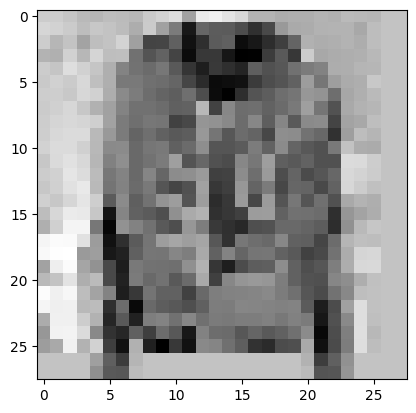

1/1 [==============================] - 0s 29ms/step
Predicted: Sandal


In [30]:
idx = int(np.random.choice(X_train.shape, 1))
sample_image = X_train[idx]
print("Original label ",LABELS[y_train[idx]])
perturbed_image = perturb_image(sample_image, y_train[idx], 5, apparel_model)

The generator is able to predict the perturbed image as a fake one.

In [36]:
disc.predict(perturbed_image)

1/1 [==============================] - 0s 118ms/step


array([[0.99668485]], dtype=float32)